
------------|--------------|------|----------|----------|--------------|--------------|----------------
 Eb/NO (dB) | Frame number |  FE  |    BER   |    FER   |  Tpt (Mbps)  | Elapsed Time | Remaining Time 
------------|--------------|------|----------|----------|--------------|--------------|----------------


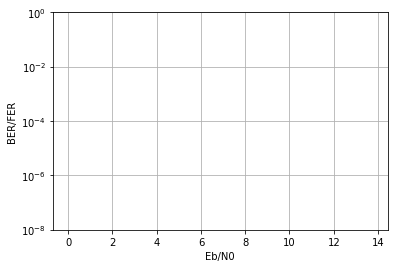

       0.00 |         1028 | 1028 | 4.38e-01 | 1.00e+00 |          1.18|     00:00:00 |       00:00:00
       0.25 |         1028 | 1028 | 4.35e-01 | 1.00e+00 |          1.23|     00:00:00 |       00:00:00
       0.50 |         1028 | 1028 | 4.33e-01 | 1.00e+00 |          1.23|     00:00:00 |       00:00:00
       0.75 |         1028 | 1028 | 4.31e-01 | 1.00e+00 |          1.23|     00:00:00 |       00:00:00
       1.00 |         1028 | 1028 | 4.28e-01 | 1.00e+00 |          1.24|     00:00:00 |       00:00:00
       1.25 |         1028 | 1028 | 4.25e-01 | 1.00e+00 |          1.20|     00:00:00 |       00:00:00
       1.50 |         1028 | 1028 | 4.22e-01 | 1.00e+00 |          1.20|     00:00:00 |       00:00:00
       1.75 |         1028 | 1028 | 4.19e-01 | 1.00e+00 |          1.14|     00:00:00 |       00:00:00
       2.00 |         1028 | 1028 | 4.17e-01 | 1.00e+00 |          1.15|     00:00:00 |       00:00:00
       2.25 |         1028 | 1028 | 4.12e-01 | 1.00e+00 |          1.20| 

In [2]:
#!/usr/bin/env python3
import sys

from numpy.core.numeric import Infinity
sys.path.insert(0, '../../build/lib')
import os
os.system('stty -echoctl')

import math
import py_aff3ct as aff3ct
from py_loop_counter import loop_counter
from py_signal_catcher import signal_catcher
import numpy as np
import time
import matplotlib.pyplot as plt
import threading

class seq_execution(threading.Thread):
    def __init__(self, seq):
        threading.Thread.__init__(self)
        self.seq = seq
        self.starting_time = time.time()

    def run(self):
        self.starting_time = time.time()
        self.seq.exec()

K = 1024   # Message length
N = 2052  # Codeword length
I = 4    # Turbo-iterations number
T = 8    # Number of threads
F = 4
FE = 1000 # number of frame errors
bps = 4  # Number of bits per symbols

Ns = N//bps
ebn0_min = 0
ebn0_max = 14.0
ebn0_step = 0.25

ebn0 = np.arange(ebn0_min,ebn0_max,ebn0_step)
esn0 = ebn0 + 10 * math.log10(K/Ns)
sigma_vals = 1/(math.sqrt(2) * 10 ** (esn0 / 20))

src      = aff3ct.module.source.Source_random_fast(K  )
enc      = aff3ct.module.encoder.Encoder_RSC_generic_sys(K,N)
cstl     = aff3ct.tools.constellation.Constellation_user("../../lib/aff3ct/conf/mod/16QAM_ANTI_GRAY.mod") # Setup constellation tool
mdm      = aff3ct.module.modem.Modem_generic(N, cstl)
gen      = aff3ct.tools.Gaussian_noise_generator_implem.FAST
chn      = aff3ct.module.channel.Channel_AWGN_LLR(Ns*2, gen)
itl_core = aff3ct.tools.interleaver_core.Interleaver_core_random(N)
itl_bit  = aff3ct.module.interleaver.Interleaver_int32(itl_core)
itl_llr  = aff3ct.module.interleaver.Interleaver_float(itl_core)
dec      = aff3ct.module.decoder.Decoder_RSC_BCJR_seq_generic_std(K,enc.get_trellis())
mnt      = aff3ct.module.monitor.Monitor_BFER_AR(K, FE)
swi      = aff3ct.module.switcher.Switcher(2, N, np.float32)
cnt      = aff3ct.module.iterator.Iterator(I)
sgc      = signal_catcher()

enc    ["encode       ::U_K  "] = src    ["generate    ::U_K   "]
itl_bit["interleave   ::nat  "] = enc    ["encode      ::X_N   "]
mdm    ["modulate     ::X_N1 "] = itl_bit["interleave  ::itl   "]
chn    ["add_noise    ::X_N  "] = mdm    ["modulate    ::X_N2  "]
mdm    ["tdemodulate  ::Y_N1 "] = chn    ["add_noise   ::Y_N   "]
mdm    ["tdemodulate  ::Y_N2 "] = swi    ["select      ::data  "]
itl_llr["deinterleave ::itl  "] = mdm    ["tdemodulate ::Y_N3  "]
swi    ["commute      ::data "] = itl_llr["deinterleave::nat   "]
dec    ["decode_siso  ::Y_N1 "] = swi    ["commute     ::data0 "]
itl_llr["interleave   ::nat  "] = dec    ["decode_siso ::Y_N2  "]
swi    ["select       ::data0"] = itl_llr["interleave  ::itl   "]
swi    ["commute      ::ctrl "] = cnt    ["iterate     ::out   "]
cnt    ["iterate"             ] = swi    ["select      ::status"]
dec    ["decode_siho  ::Y_N  "] = swi    ["commute     ::data1 "]
mnt    ["check_errors ::U    "] = src    ["generate    ::U_K   "]
mnt    ["check_errors ::V    "] = dec    ["decode_siho ::V_K   "]
sgc    ["do_nothing"          ] = mnt    ["check_errors::status"]

seq  = aff3ct.tools.sequence.Sequence([src["generate"], swi["select"]],1)
seq.set_n_frames(F)
seq.export_dot("seq_tdb.dot")
sigma = np.ndarray(shape = chn["add_noise::CP"][:].shape, dtype = np.float32)
Z     = np.zeros  (shape = swi["select::data1"][:].shape, dtype = np.float32)
chn    ["add_noise    ::CP   "] = sigma
mdm    ["tdemodulate  ::CP   "] = sigma
swi    ["select       ::data1"] = Z

seq  = aff3ct.tools.sequence.Sequence([src["generate"], swi["select"]],T)

seq.export_dot('test.dot')
l_tasks = seq.get_tasks_per_types()
for lt in l_tasks:
    for t in lt:
        t.stats = True

seeders = seq.get_modules_set_seed()
for mdl in seeders:
    mdl.set_seed(np.random.randint(3242, dtype=int))

fer = np.zeros(len(ebn0))
ber = np.zeros(len(ebn0))

fig = plt.figure()
ax = fig.add_subplot(111)
line1,line2, = ax.semilogy(ebn0, fer, 'r-', ebn0, ber, 'b--', nonpositive='mask') # Returns a tuple of line objects, thus the comma
plt.ylim((1e-8, 1))
plt.xlabel("Eb/N0")
plt.ylabel("BER/FER")
plt.grid()
print("")
print("------------|--------------|------|----------|----------|--------------|--------------|----------------")
print(" Eb/NO (dB) | Frame number |  FE  |    BER   |    FER   |  Tpt (Mbps)  | Elapsed Time | Remaining Time ")
print("------------|--------------|------|----------|----------|--------------|--------------|----------------")

for i in range(len(sigma_vals)):
    mnt.reset()
    se = seq_execution(seq=seq)
    se.start() # start simulation threads

    # Main thread : update display (console and curves)
    sigma[:,:] = sigma_vals[i]
    remaining = 0
    while se.is_alive():

        elapsed   = time.time() - se.starting_time
        total_fra = mnt.get_n_analyzed_fra()
        ber[i]    = mnt.get_ber()
        fer[i]    = mnt.get_fer()
        n_fe      = mnt.get_n_fe()
        tpt       = total_fra * K * 1e-6/elapsed

        if n_fe == 0:
            print("%11.2f | %12d | %4d |       -- |       -- |           -- | %12s | %14s"%(ebn0[i], total_fra, n_fe, time.strftime('%H:%M:%S', time.gmtime(elapsed)), '--:--:--'), end="\r")
        else:
            remaining = max((elapsed/n_fe)*(FE-n_fe),0)
            print("%11.2f | %12d | %4d | %7.2e | %7.2e | %13.2f| %12s | %14s"%(ebn0[i], total_fra, n_fe, ber[i], fer[i], tpt, time.strftime('%H:%M:%S', time.gmtime(elapsed)), time.strftime('%H:%M:%S', time.gmtime(remaining))), end="\r")

        line1.set_ydata(fer)
        line2.set_ydata(ber)
        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.pause(0.05)
        #time.sleep(0.125)

    elapsed   = time.time() - se.starting_time
    total_fra = mnt.get_n_analyzed_fra()
    ber[i]    = mnt.get_ber()
    fer[i]    = mnt.get_fer()
    n_fe      = mnt.get_n_fe()
    tpt       = total_fra * K * 1e-6/elapsed
    if n_fe >= FE:
        print("%11.2f | %12d | %4d | %7.2e | %7.2e | %13.2f| %12s | %14s"%(ebn0[i], total_fra, n_fe, ber[i], fer[i], tpt, time.strftime('%H:%M:%S', time.gmtime(elapsed)), time.strftime('%H:%M:%S', time.gmtime(0))), end="\n")
    else:
        print("%11.2f | %12d | %4d | %7.2e | %7.2e | %13.2f| %12s | %14s x"%(ebn0[i], total_fra, n_fe, ber[i], fer[i], tpt, time.strftime('%H:%M:%S', time.gmtime(elapsed)), time.strftime('%H:%M:%S', time.gmtime(0.00))), end="\n")
        break

print("")
seq.show_stats()
plt.show()

